In [43]:
#import package
import os,math
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmasher as cmr
from scipy import ndimage
import warnings
from scipy.ndimage import distance_transform_edt
warnings.filterwarnings('ignore')
Pi = math.pi
font1 = {'family' : 'Times New Roman',
'weight' : 'black',
'size'   : 18}
font2 = {'family' : 'Times New Roman',
'weight' : 'black',
'size'   : 22}
plt.style.use('seaborn-poster')
plt.rcParams['axes.grid'] = 'False'
plt.rcParams['grid.alpha'] = 0.3

In [2]:
os.chdir('/Users/chenqianhui/Program/SpiralGal/')
import Identify_spiral_packages as ISP


gal_id: 2111 re: 0.95 pa: 140.28893539259082 q: 0.5 incl: 62.114433163906284 n: 2.39
x_lim0: 44 x_lim1: 197 y_lim0: 44 y_lim1: 197


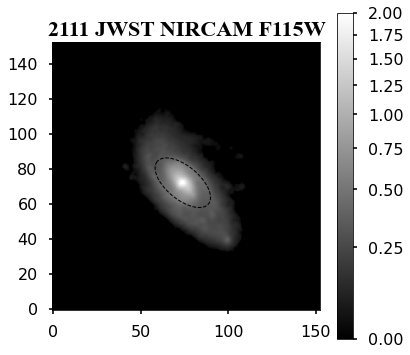

In [3]:
gal_id = ['2111']
re, pa, q, incl, n = ISP.get_pa(gal_id[0])  # get the parameters from galfit catalog updated
print('gal_id:', gal_id[0], 're:', re, 'pa:', pa, 'q:', q, 'incl:', incl, 'n:', n)

img, xc, yc, cutout_edge, re_inpix = ISP.get_image(gal_id[0], re, pa, q)  # get the image and parameters
dedist = ISP.get_dedist(img, xc, yc, pa, incl)
phi0_im = ISP.cal_phi_map(img, xc, yc, pa, incl)

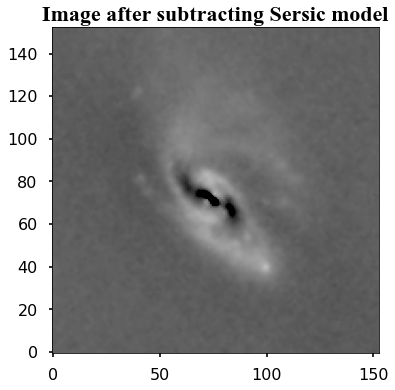

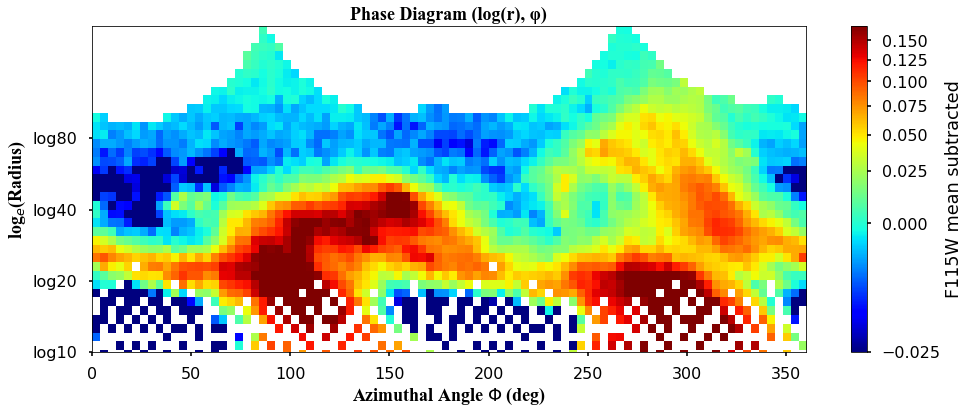

In [4]:
ny, nx = img.shape
y, x = np.mgrid[0:ny, 0:nx]
# xc, yc = center coordinates
# re = effective radius (in pixels)
# n = Sersic index (for disc, n=1)
# q = axis ratio
# pa = position angle (degrees)
# Ie = intensity at re (estimate from your data or fit)
sersic_model = ISP.sersic_2d(x, y, xc, yc, re_inpix, n, q, pa, Ie=0.1)  # Adjust Ie as needed
im_submean = img - sersic_model
plt.figure(figsize=(6, 6))
plt.title('Image after subtracting Sersic model', fontdict=font2)
plt.imshow(im_submean, norm=mcolors.PowerNorm(gamma=0.5, vmin=-0.1, vmax=0.6), cmap='gray', origin='lower')

phase_dig, r_bins, phi_bins = ISP.img2phase(im_submean, dedist, phi0_im)

In [5]:
#Detect the peaks in the phase map
phase_dig = phase_dig[20:,:]  # Adjust this slice as needed
marker1 = ISP.find_peak_cnt(ndimage.gaussian_filter(np.where(phase_dig>0, phase_dig, 0), sigma=1), 
                        3, np.percentile(phase_dig[phase_dig>0], 10)/2., np.percentile(phase_dig[phase_dig>0], 5)/2.)#try to guide the ant to walk out the brightest spiral arm

#cover the brightest spiral arm with the first mask
im_phase_2 = np.copy(phase_dig)
for i in range(0, phase_dig.shape[0]):
    for j in range(0, phase_dig.shape[1]):
        if np.nansum(marker1[i-2: i+2, j-2: j+2])>0:
            im_phase_2[i][j] = 0 #mask out the brightes spiral arm, given the width of 2 grid in R direction and φ direction
marker2 = ISP.find_peak_cnt(ndimage.gaussian_filter(np.where(im_phase_2>0, im_phase_2, 0), sigma=1), 
                        3, np.percentile(phase_dig[phase_dig>0], 10)/2., np.percentile(phase_dig[phase_dig>0], 5)/2.) #guide the ant to walk out the second brightest spiral arm

#delete the pixels duplicated or too close to each other
for i in range(3, marker2.shape[0]-3):
    for j in range(3, marker2.shape[1]-3):
        if np.nansum(marker1[i-4:i+4, j-4:j+4]) > 0:
            marker2[i][j] = np.nan

In [7]:
phi_min, phi_max = 150, 250  # Define the range of phi for interpolation
spline = ISP.interpolate_spiral_arm(marker1, r_bins, phi_bins, phi_min, phi_max)
for i in range(0, marker1.shape[1]):
    if phi_bins[i] < phi_min or phi_bins[i] > phi_max:
            continue
    r_target = spline(phi_bins[i])  # Get the interpolated radius for this phi
    r_target_ind = np.argmin(np.abs(r_bins - r_target))  # Find the closest radius index
    marker1[r_target_ind][i] = 1  # Set the mask at this radius index

In [8]:
phi_min, phi_max = 260, 300  # Define the range of phi for interpolation
spline = ISP.interpolate_spiral_arm(marker1, r_bins, phi_bins, phi_min, phi_max)
for i in range(0, marker1.shape[1]):
    if phi_bins[i] < phi_min or phi_bins[i] > phi_max:
            continue
    r_target = spline(phi_bins[i])  # Get the interpolated radius for this phi
    r_target_ind = np.argmin(np.abs(r_bins - r_target))  # Find the closest radius index
    marker1[r_target_ind][i] = 1  # Set the mask at this radius index

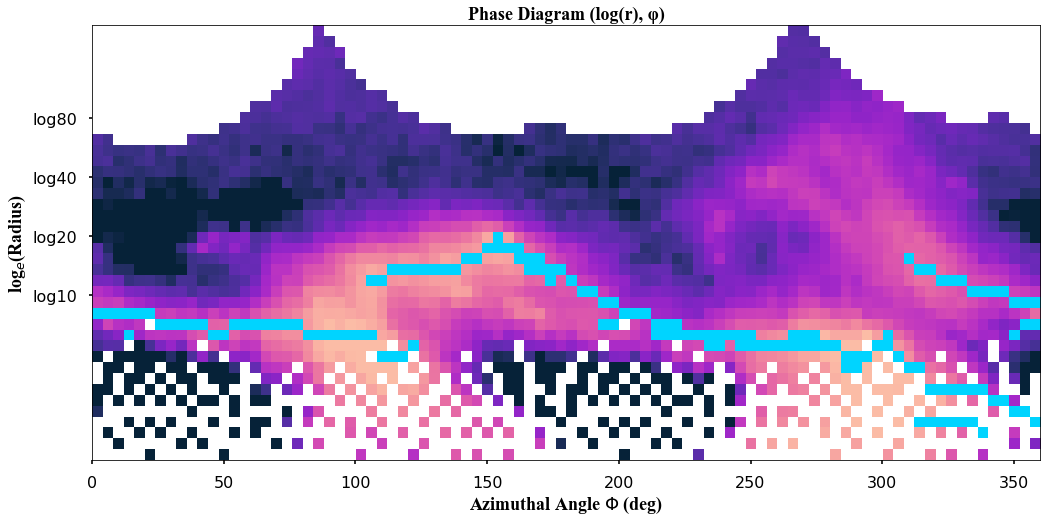

In [9]:
# Visualise the phase diagram with both marker1 and marker2 overlaid
fig, ax = plt.subplots(figsize=[17, 8])
# Show the phase diagram
im = ax.imshow(phase_dig,
    norm=mcolors.PowerNorm(gamma=0.5, vmin=np.nanpercentile(phase_dig, 10), vmax=np.nanpercentile(phase_dig, 98)),
    extent=[phi_bins[0], phi_bins[-1], np.log(r_bins[0]), np.log(r_bins[-1])],
    aspect='auto', cmap=cmr.bubblegum, origin='lower'
)
ax.set_xlabel('Azimuthal Angle $\\Phi$ (deg)', font1)
ax.set_ylabel('log$_e$(Radius)', font1)
ax.set_yticks([ np.log(10), np.log(20), np.log(40), np.log(80)],  # adjust step for readability
    labels=['log10', 'log20', 'log40', 'log80'])
# ax.set_ylim(np.log(10), np.log(r_bins[-1]))

# Overlay marker
ax.imshow(np.where( (marker1 > 0) | (marker2 >0), 1, np.nan), cmap='jet_r', alpha=1,
              vmin=0, vmax=1.5, origin='lower', aspect='auto',
    extent=[phi_bins[0], phi_bins[-1], np.log(r_bins[0]), np.log(r_bins[-1])]
)


plt.title('Phase Diagram (log(r), φ)', font1)
plt.show()

# marker_tot = np.where( (marker1 > 0) | (marker2 >0), 1, np.nan)

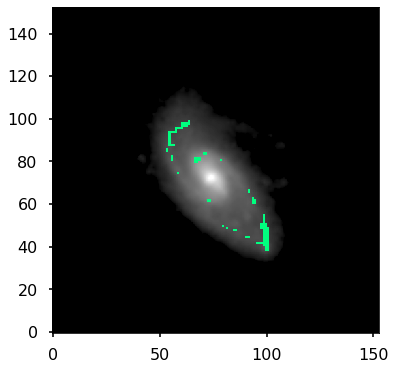

In [90]:
#Recover the markers to the original phase diagram size
marker1 = np.vstack([np.full([len(r_bins) - marker1.shape[0] - 1, marker1.shape[1]], 0), marker1])
marker2 = np.vstack([np.full([len(r_bins) - marker2.shape[0] - 1, marker2.shape[1]], 0), marker2])

#revert the markers to the image shape
spmask = ISP.marker2spiral_map(img, marker1, marker2, r_bins, phi_bins, dedist, phi0_im)
plt.figure(figsize=(6, 6))
plt.imshow(img, norm=mcolors.PowerNorm(gamma=0.5, vmin=0.1, vmax=2), cmap='gray', origin='lower')

# spmask_binary = np.where(spmask > 0, 1, 0)
# spmask_smooth = ndimage.gaussian_filter(spmask_binary.astype(float), sigma=1)
# spmask_smooth = np.where( (spmask_smooth >= 0.4) | (spmask>0), 1, np.nan)

spmask_binary = np.where(spmask > 0, 1, 0)


# Morphological closing to fill small gaps and connect pixels
spmask_closed = ndimage.binary_closing(spmask_binary, structure=np.ones((3,3))).astype(float)
spmask_closed = np.where(spmask_closed == 0, np.nan, spmask_closed)
plt.imshow(spmask_closed, vmax=1, cmap='winter_r', origin='lower')
plt.savefig('/Users/chenqianhui/Program/SpiralGal/MSA-3D/2111_spmask.png', dpi=300, bbox_inches='tight')

spmask_width = np.where(distance_transform_edt(1-spmask_closed) <= 1., 1, np.nan) 
# plt.imshow(spmask_width, vmax=1, cmap='winter_r', origin='lower')
# plt.savefig('/Users/chenqianhui/Program/SpiralGal/MSA-3D/2111_spmask_width.png', dpi=300, bbox_inches='tight')

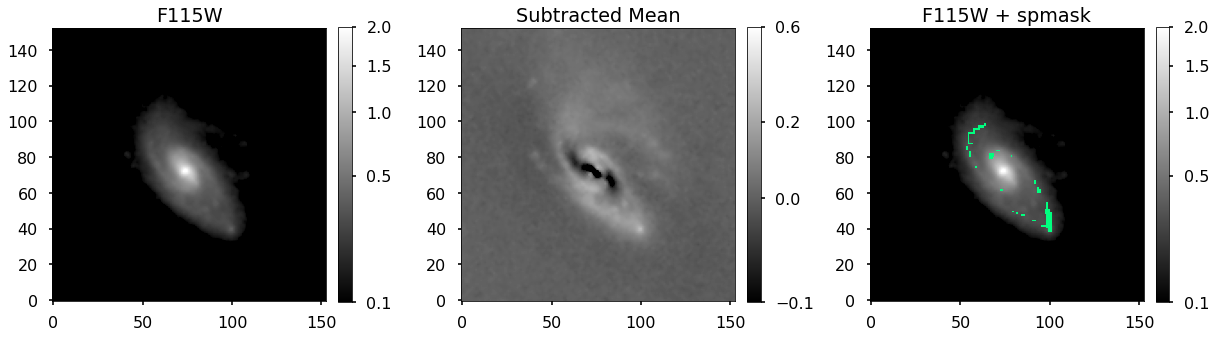

In [91]:
ISP.compare_img_spmask(img, im_submean, spmask = spmask_closed, isSave = True)

In [ ]:
spmask_final = ISP.complete_spmask(spmask, cutout_edge, isSave = True, gal_name=gal_id[0], file_name='spmask_width')